<!-- <p style="font-size:22px;font-weight:bold"> Table of Contents</p> -->
 

# Table of Contents

1. [Introduction](#introduction)

    1.1. [Data Description](#data_description)
    
    1.2. [Data Source](#data_source)
2. [Exploratory Data Analysis](#EDA)

    2.1. [Data Cleaning](#data_cleaning)
    
    2.2. [Removing Outliers](#remove_outlier)
    
    2.3. [Droping columns](#drop_column)
    
3. [Feature Engineering](#feature_engineering)

4. [Split the data into train and test](#split_data)

5. [Model Creation](#model_creat)


    

    

  

  




# Introduction <a class="anchor" id="introduction"></a>


## Data description <a class="anchor" id ="data_description"></a>

Wind Turbine Energy Generation Data

The data set consists of real-time SCADA data. Each data value belongs only to the relevant time period and the input variables transmitted in the data set for the time period to be predicted are prepared to be used to predict the power generation result in the same time period.


In The Power Table:
In the shared dataset, the real-time power generation amount (Power(kW)) of a wind turbine between 01.01.2019 and 14.08.2021 is given on a 10-minute basis.

In The Features Table
In addition to real-time power generation; Some SCADA data of the wind turbine were shared for the date range 01.01.2019 – 14.12.2021.

### Data source <a class="anchor" id="data_source"></a>

Batucan Senkal,(2022, October). Wind Turbine Power (kW) Generation Data, Version 9. Retrieved October 8, 2023 from https://www.kaggle.com/datasets/psycon/wind-turbine-energy-kw-generation-data/.



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from prophet import Prophet
import xgboost as xgb

import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

# Load Data

In [2]:
# loading the power data and converting the timestamp as index
df_power=pd.read_csv('/kaggle/input/wind-turbine-energy-kw-generation-data/power.csv')
df_power['Timestamp']=pd.to_datetime(df_power['Timestamp'])
df_power.set_index('Timestamp',inplace=True)
print(df_power.head(3))

# loading the feature data and split it in to two parts train and test based on the timestamp
df_feature=pd.read_csv('/kaggle/input/wind-turbine-energy-kw-generation-data/features.csv')
df_feature['Timestamp']=pd.to_datetime(df_feature['Timestamp'])
df_feature.set_index('Timestamp',inplace=True)
df_feature.head(3)




                      Power(kW)
Timestamp                      
2019-01-01 00:00:00  705.876648
2019-01-01 00:10:00  884.711670
2019-01-01 00:20:00  982.875000


,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,N-set 1,Operating State,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Pitch Offset-2 Asymmetric Load Controller,Pitch Offset Tower Feedback,Line Frequency,Internal Power Limit,Circuit Breaker cut-ins,Particle Counter,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,External Power Limit,Blade-2 Actual Value_Angle-B,Blade-1 Actual Value_Angle-B,Blade-3 Actual Value_Angle-B,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Pitch Offset-1 Asymmetric Load Controller,Tower Deflection,Pitch Offset-3 Asymmetric Load Controller,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,State and Fault,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Turbine State,Proxy Sensor_Degree-315
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,56.158333,55.000000,55.000000,35.873798,-205.350006,57.0,-212.126663,28.000000,52.618332,264.949768,265.629913,1735.0,16.0,-0.953030,25.0,20.110001,395.029999,17.715000,392.086670,20.0,20.0,392.413330,10.773334,682.044983,11.0,12.0,11.0,72.210175,181.896973,15.140000,0.0,0.0,50.018833,2780.0,395.0,0.0,-0.072567,0.076724,3300.0,0.0,0.0,0.0,24.0,-1.582408,3.976667,-0.761741,0.0,3138.0,0.0,-2.923333,-3.011667,5.909392,2.0,5.957316,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,37.867054,39.281124,5.732657,1.0,5.779913
2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,57.000000,55.174999,55.174999,41.370548,-176.223328,57.0,-183.403336,28.000000,53.060001,3.340425,3.055089,1735.0,16.0,-0.971856,25.0,20.424999,396.133331,17.459999,392.931671,20.0,20.0,393.040009,4.976666,683.515015,11.0,12.0,11.0,72.220482,178.224670,14.948334,0.0,0.0,50.006634,2780.0,395.0,0.0,2.632190,0.323242,3300.0,0.0,0.0,0.0,24.0,-2.231261,4.000000,-0.777843,0.0,3138.0,0.0,-3.033333,-2.975000,5.892997,2.0,5.868237,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-90.169106,-89.018669,5.813177,1.0,5.796757
2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,57.775002,56.000000,56.000000,44.466202,-105.058334,57.0,-112.143333,28.763334,54.000000,75.649010,75.435135,1735.0,16.0,-0.988937,25.0,21.000000,397.138336,18.000000,394.028320,20.0,20.0,393.941681,0.636667,685.244995,11.0,12.0,11.0,72.364883,184.183014,14.171667,0.0,0.0,49.989101,2780.0,395.0,0.0,2.117626,-0.032209,3300.0,0.0,0.0,0.0,24.0,-2.469615,4.000000,-0.789898,0.0,3138.0,0.0,1.053333,1.028333,5.898009,2.0,5.874691,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-88.556343,-88.422020,5.786413,1.0,5.772958


In [3]:
# # the plot shows that feature data has more data, it can be used as a test data to to predict the power 

# plt.plot(df_feature.index)
# plt.plot(df_power.index,'r')


# Exploratory Data Analysis <a class="anchor" id="EDA"></a>

In [4]:
df_feature.describe().T


,count,mean,std,min,25%,50%,75%,max
Gearbox_T1_High_Speed_Shaft_Temperature,149913.0,912.592138,9227.793931,-273.000000,44.041668,57.000000,63.033333,99999.0
Gearbox_T3_High_Speed_Shaft_Temperature,149744.0,891.237110,9104.057832,-273.000000,46.000000,58.825834,65.122238,99999.0
Gearbox_T1_Intermediate_Speed_Shaft_Temperature,150253.0,980.835404,9602.886837,-273.000000,41.483334,52.513332,58.493332,99999.0
Temperature Gearbox Bearing Hollow Shaft,150530.0,946.431211,9405.155390,16.000000,47.000000,55.000000,61.496666,99999.0
Tower Acceleration Normal,149904.0,931.591076,9287.608022,0.000000,24.448917,50.367348,84.704208,99999.0
...,...,...,...,...,...,...,...,...
Moment Q Direction,149414.0,884.318063,9411.101210,-1287.386719,-35.142965,-9.803967,21.727112,99999.0
Moment Q Filltered,149102.0,824.705343,9093.261889,-1286.707886,-35.052853,-9.622181,21.690431,99999.0
Proxy Sensor_Degree-45,150190.0,817.361875,8971.885225,-0.238800,5.725612,5.774975,5.839118,99999.0
Turbine State,150054.0,885.695176,9362.114726,1.000000,1.000000,1.000000,1.000000,99999.0


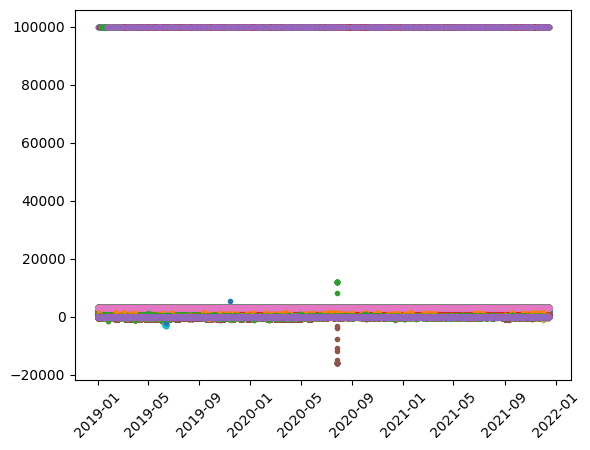

In [5]:
# the time series plot of features

for i in range(75):
    
    plt.plot(df_feature.index,df_feature.iloc[:,i].values,'.')


plt.xticks(rotation=45);


## Data Cleaning <a class="anchor" id="data_cleaning"></a>

The above time series plot shows that `99999` is a filler values therfore it is replace with `np.nan`. The time series is then individually plotted for all the feature variables to see their distribution.

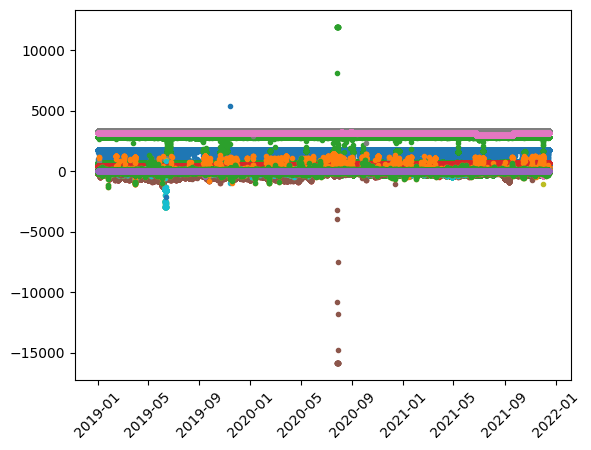

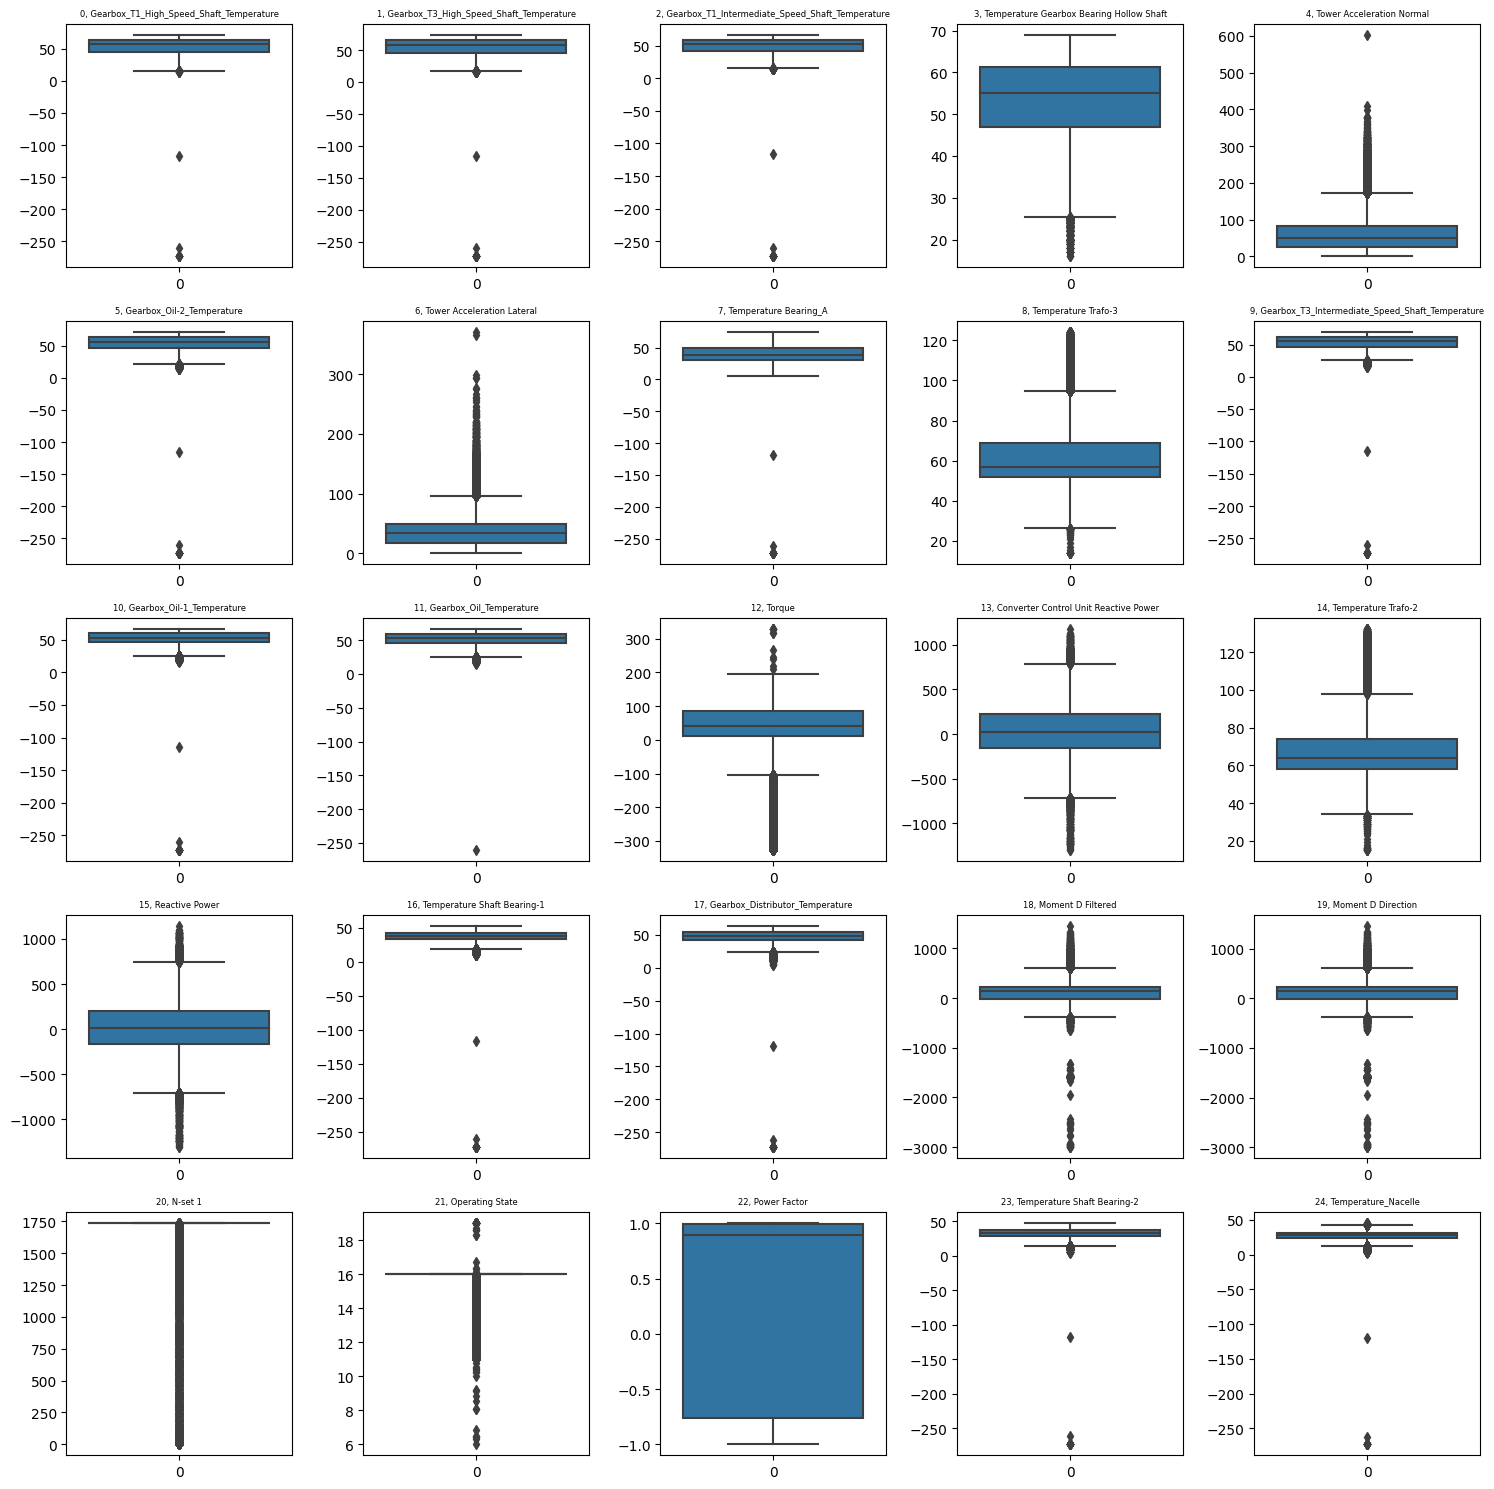

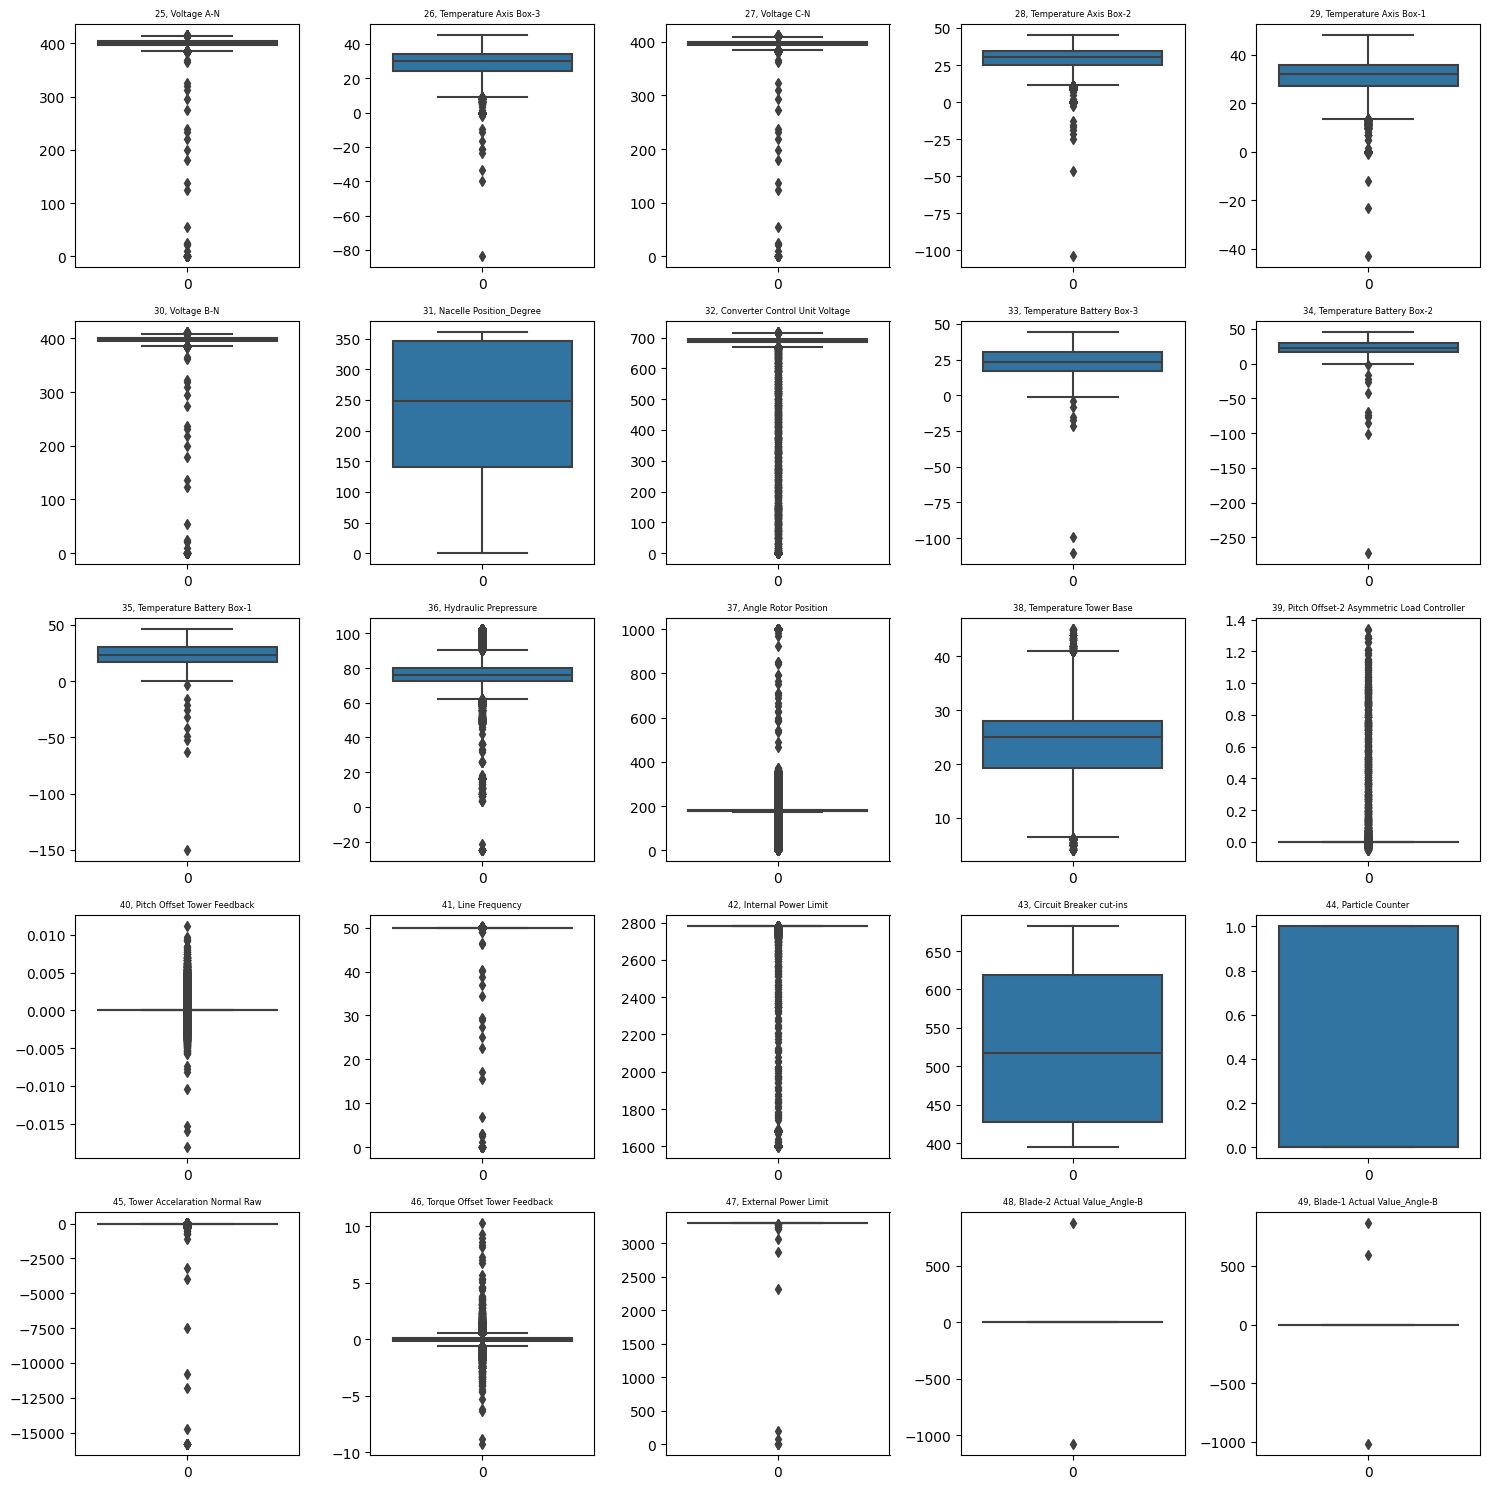

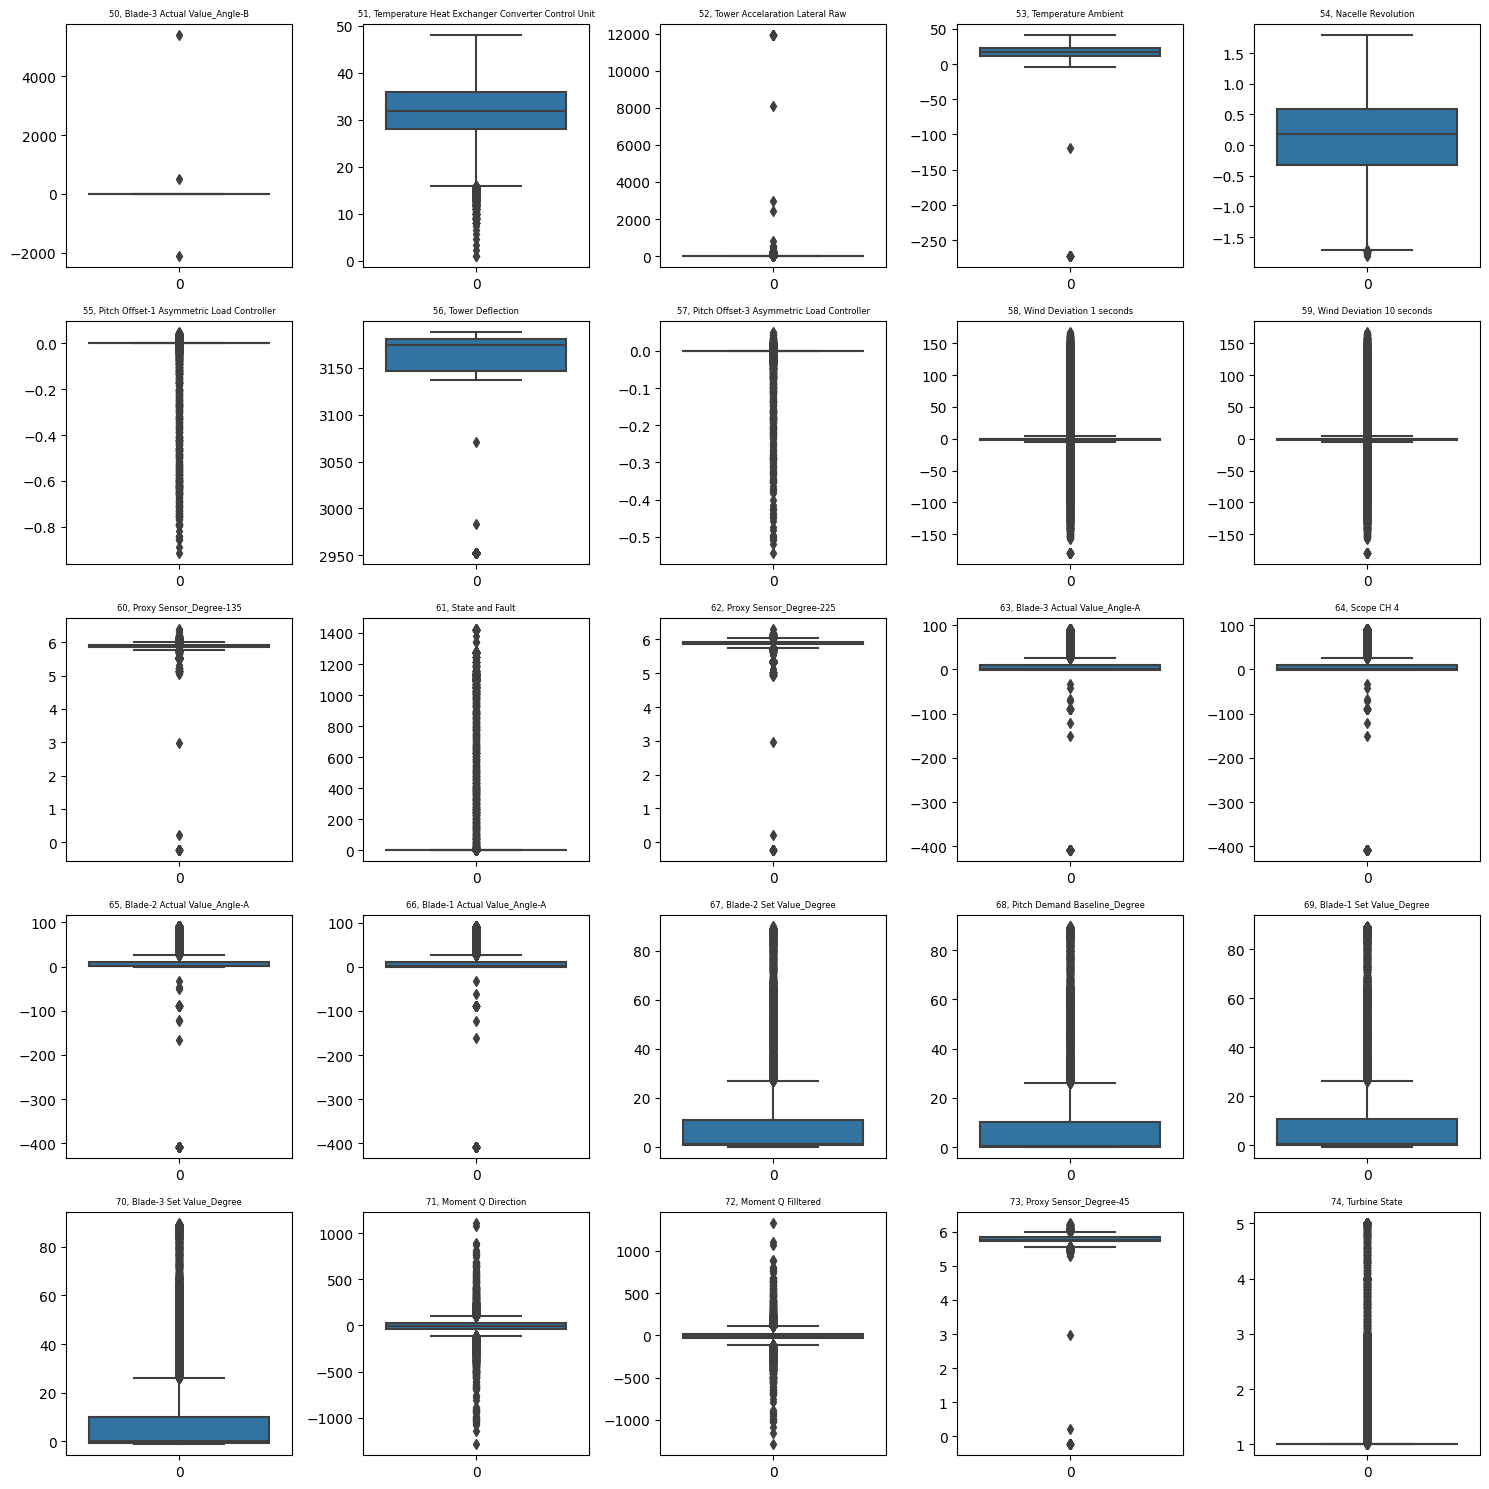

In [6]:
# replacing filler values and new time series plot
df_feature.replace(df_feature.max(),np.nan,inplace =True)
for i in range(75):
    
    plt.plot(df_feature.index,df_feature.iloc[:,i].values,'.')


plt.xticks(rotation=45);
# plt.ylim([-4000,4000])

# A function to plot subplots of large number
def fig_fun(df,ind_strt,ind_end,n_rows=5,n_cols=5,typ='line'):
    fig,axs=plt.subplots(n_rows,n_cols,figsize=(15,15))
    axs=axs.reshape(-1)
    c=0
    if typ=='line':
        for i in range(ind_strt,ind_end):
    #         sns.boxplot(df.iloc[:,i],ax=axs[c])
            axs[c].plot(df.index,df.iloc[:,i].values)
            axs[c].set_title(f'{i}, {df.iloc[:,i].name}',fontsize=6)
            axs[c].set_xticklabels(axs[c].get_xticklabels(), rotation=45, ha='right')
            axs[c].tick_params(axis='x', labelsize=6)
            c+=1
    else:
        for i in range(ind_strt,ind_end):
            sns.boxplot(df.iloc[:,i],ax=axs[c])
            
            axs[c].set_title(f'{i}, {df.iloc[:,i].name}',fontsize=6)
#             axs[c].set_xticklabels(axs[c].get_xticklabels(), rotation=45, ha='right')
#             axs[c].tick_params(axis='x', labelsize=6)
            c+=1

    plt.tight_layout()
    
# time series plot covering all the features
fig_fun(df_feature,0,25,typ='box')
plt.show()
fig_fun(df_feature,25,50,typ='box')
plt.show()
fig_fun(df_feature,50,75,typ='box')

## Removing Outliers <a class="anchor" id="remove_outlier"></a>

The boxplot shows the presence of significant outliers in the feature dataset. Consequently, the values that exceed 1.5 times the interquartile range to are removed and filled with median values




In [7]:
def remove_outliers_and_fillna(df, threshold=1.5):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    df_masked = df[~((df < lower_bound) | (df > upper_bound))]
    df_outlier_removed = df_masked.fillna(df_masked.median())

    return df_outlier_removed

df_feature_clean=remove_outliers_and_fillna(df_feature)

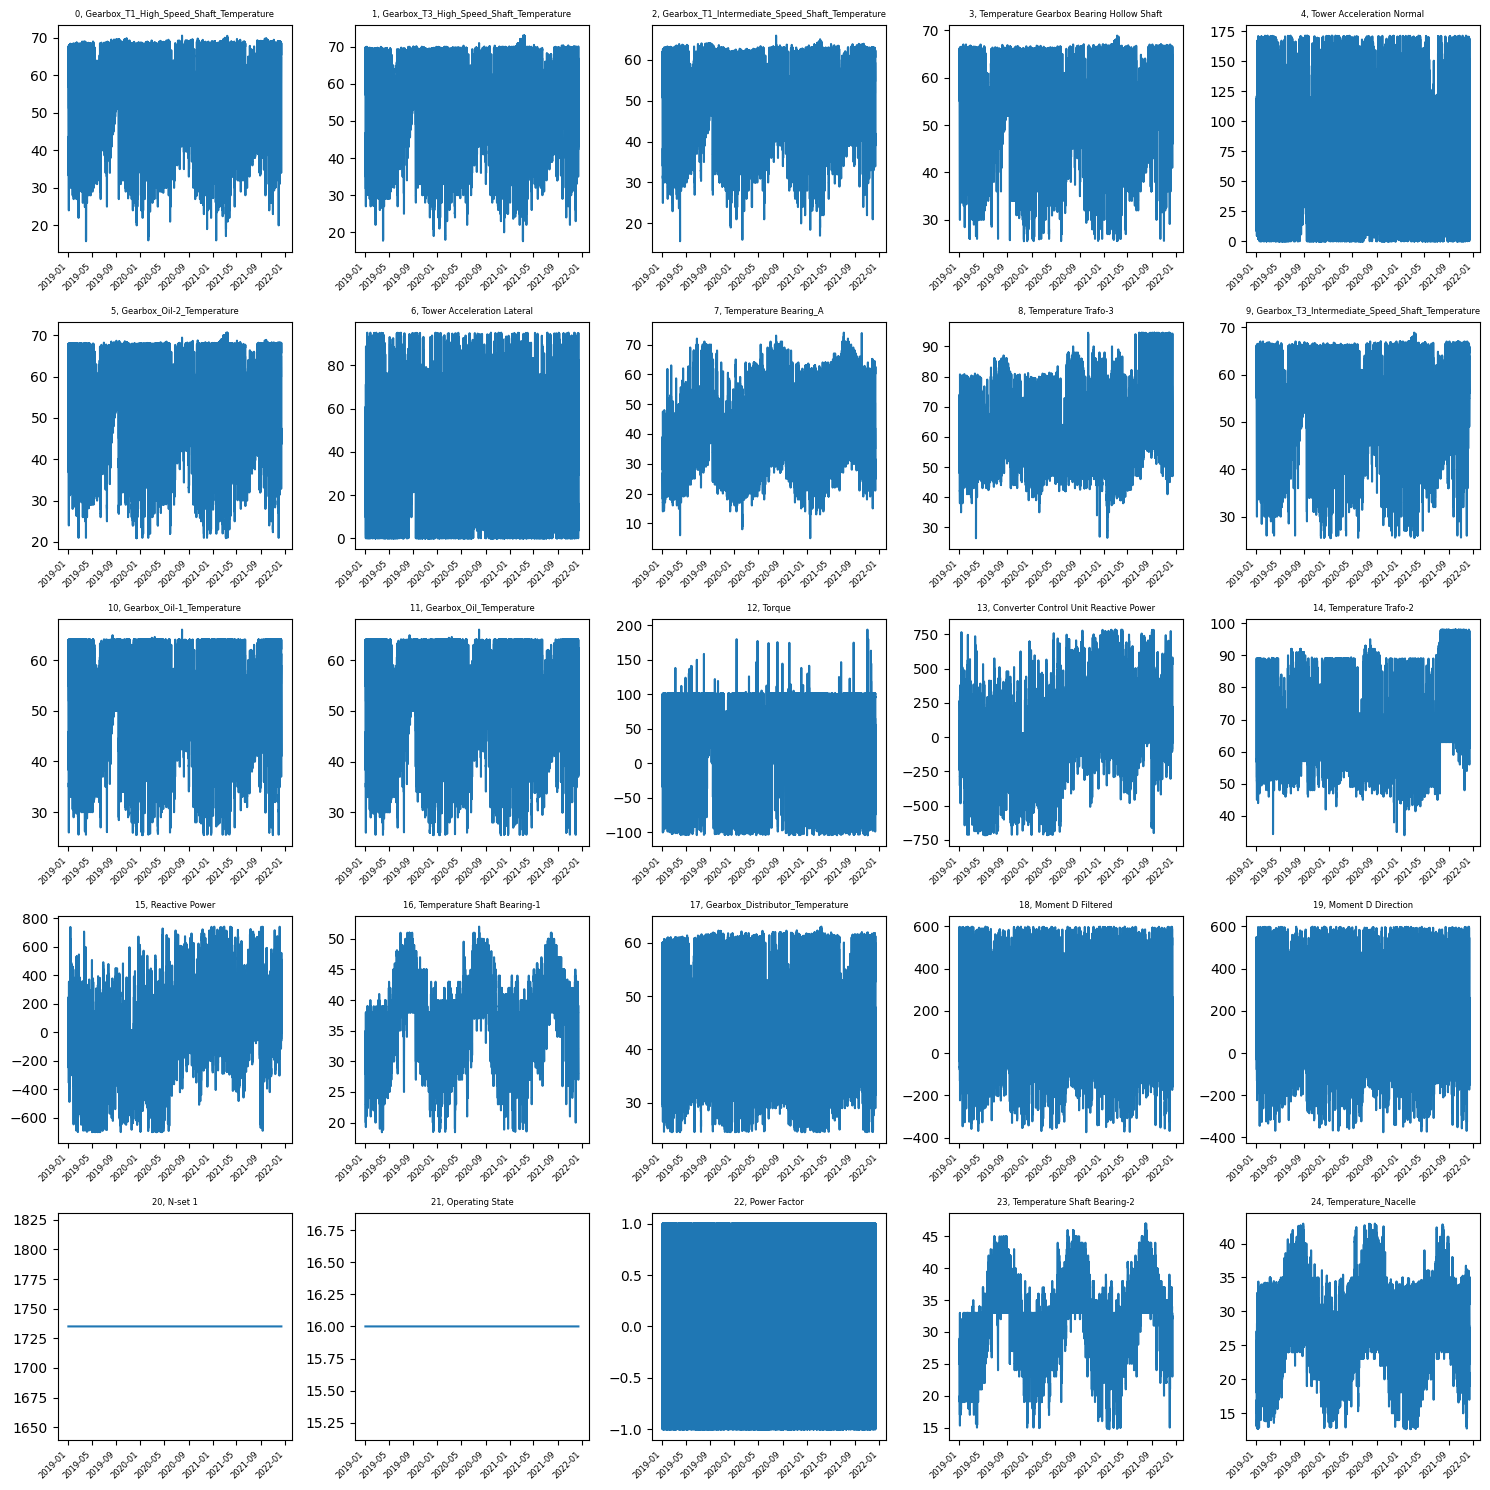

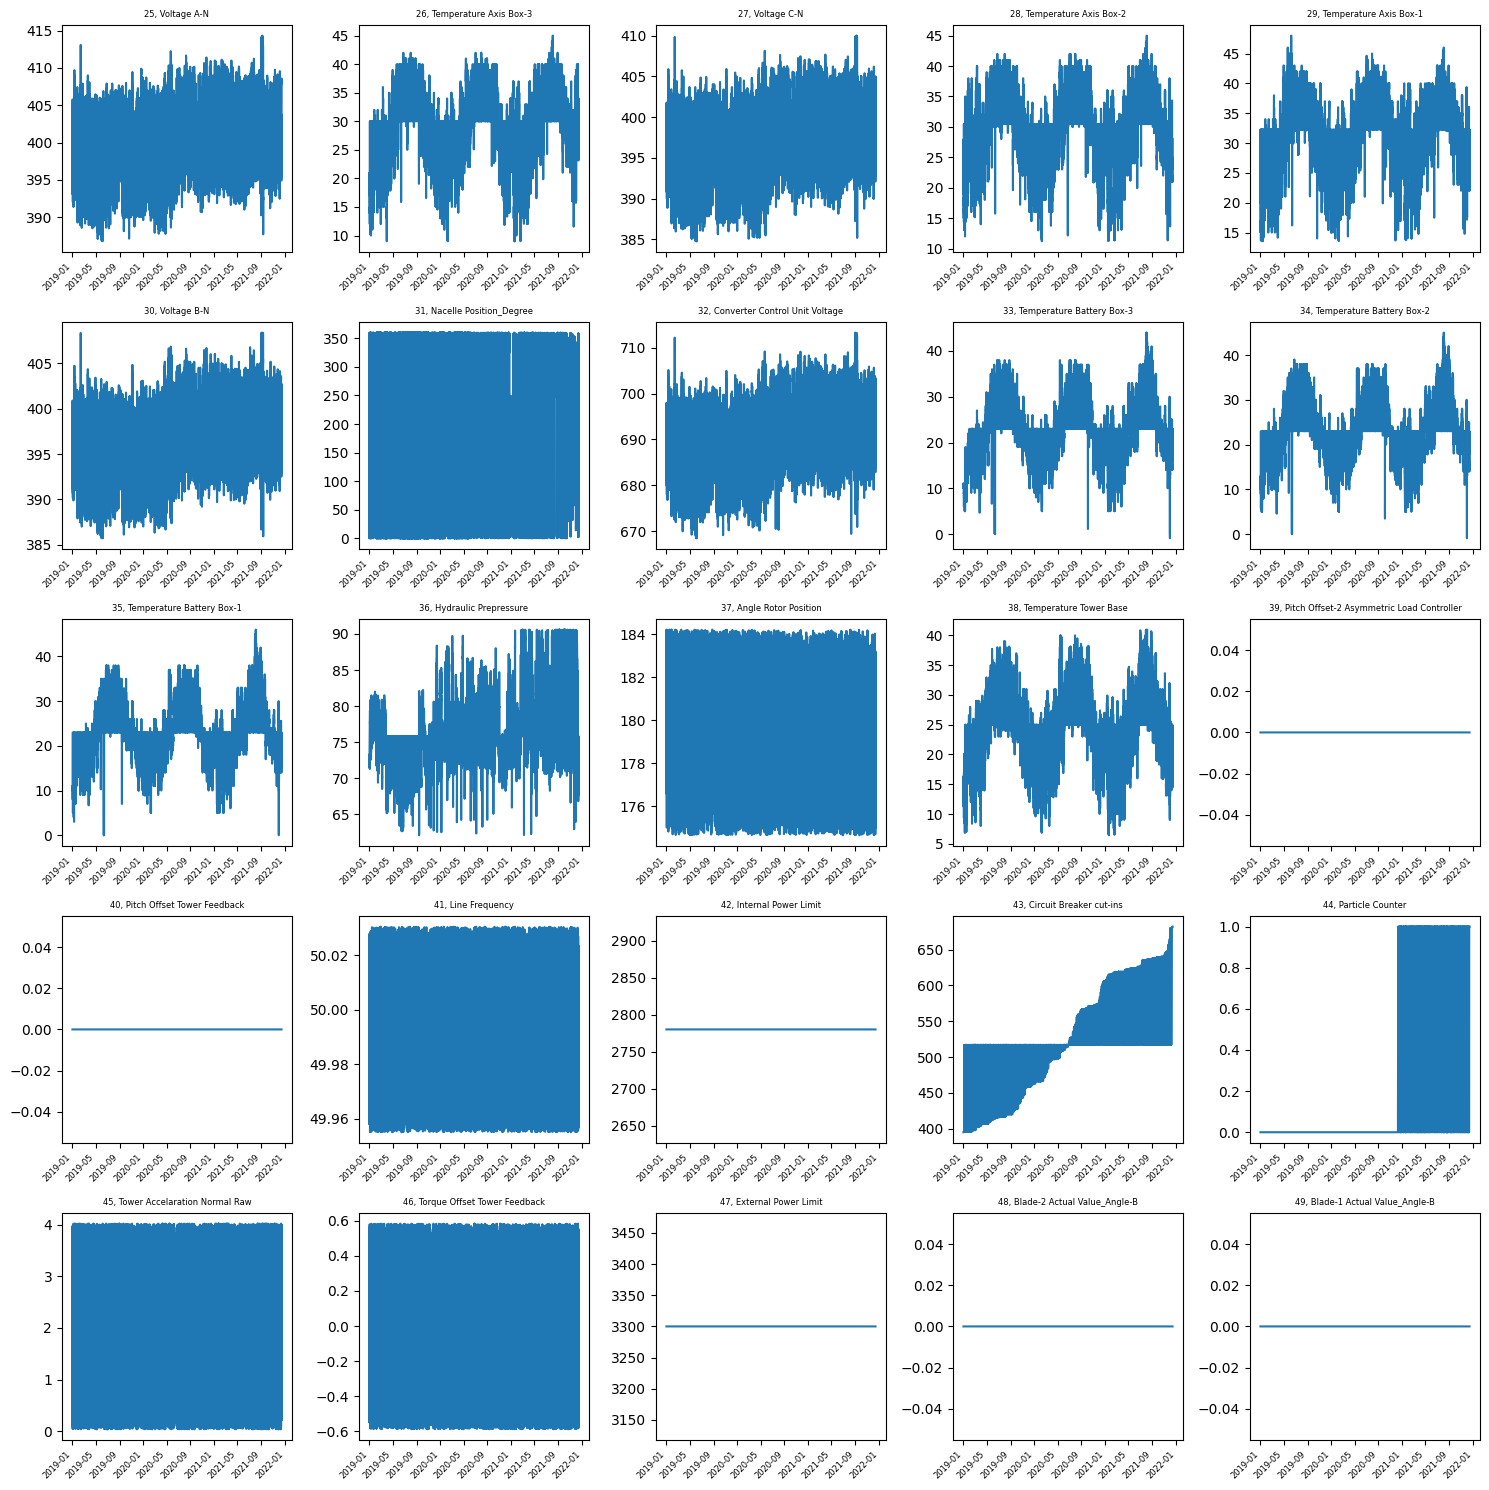

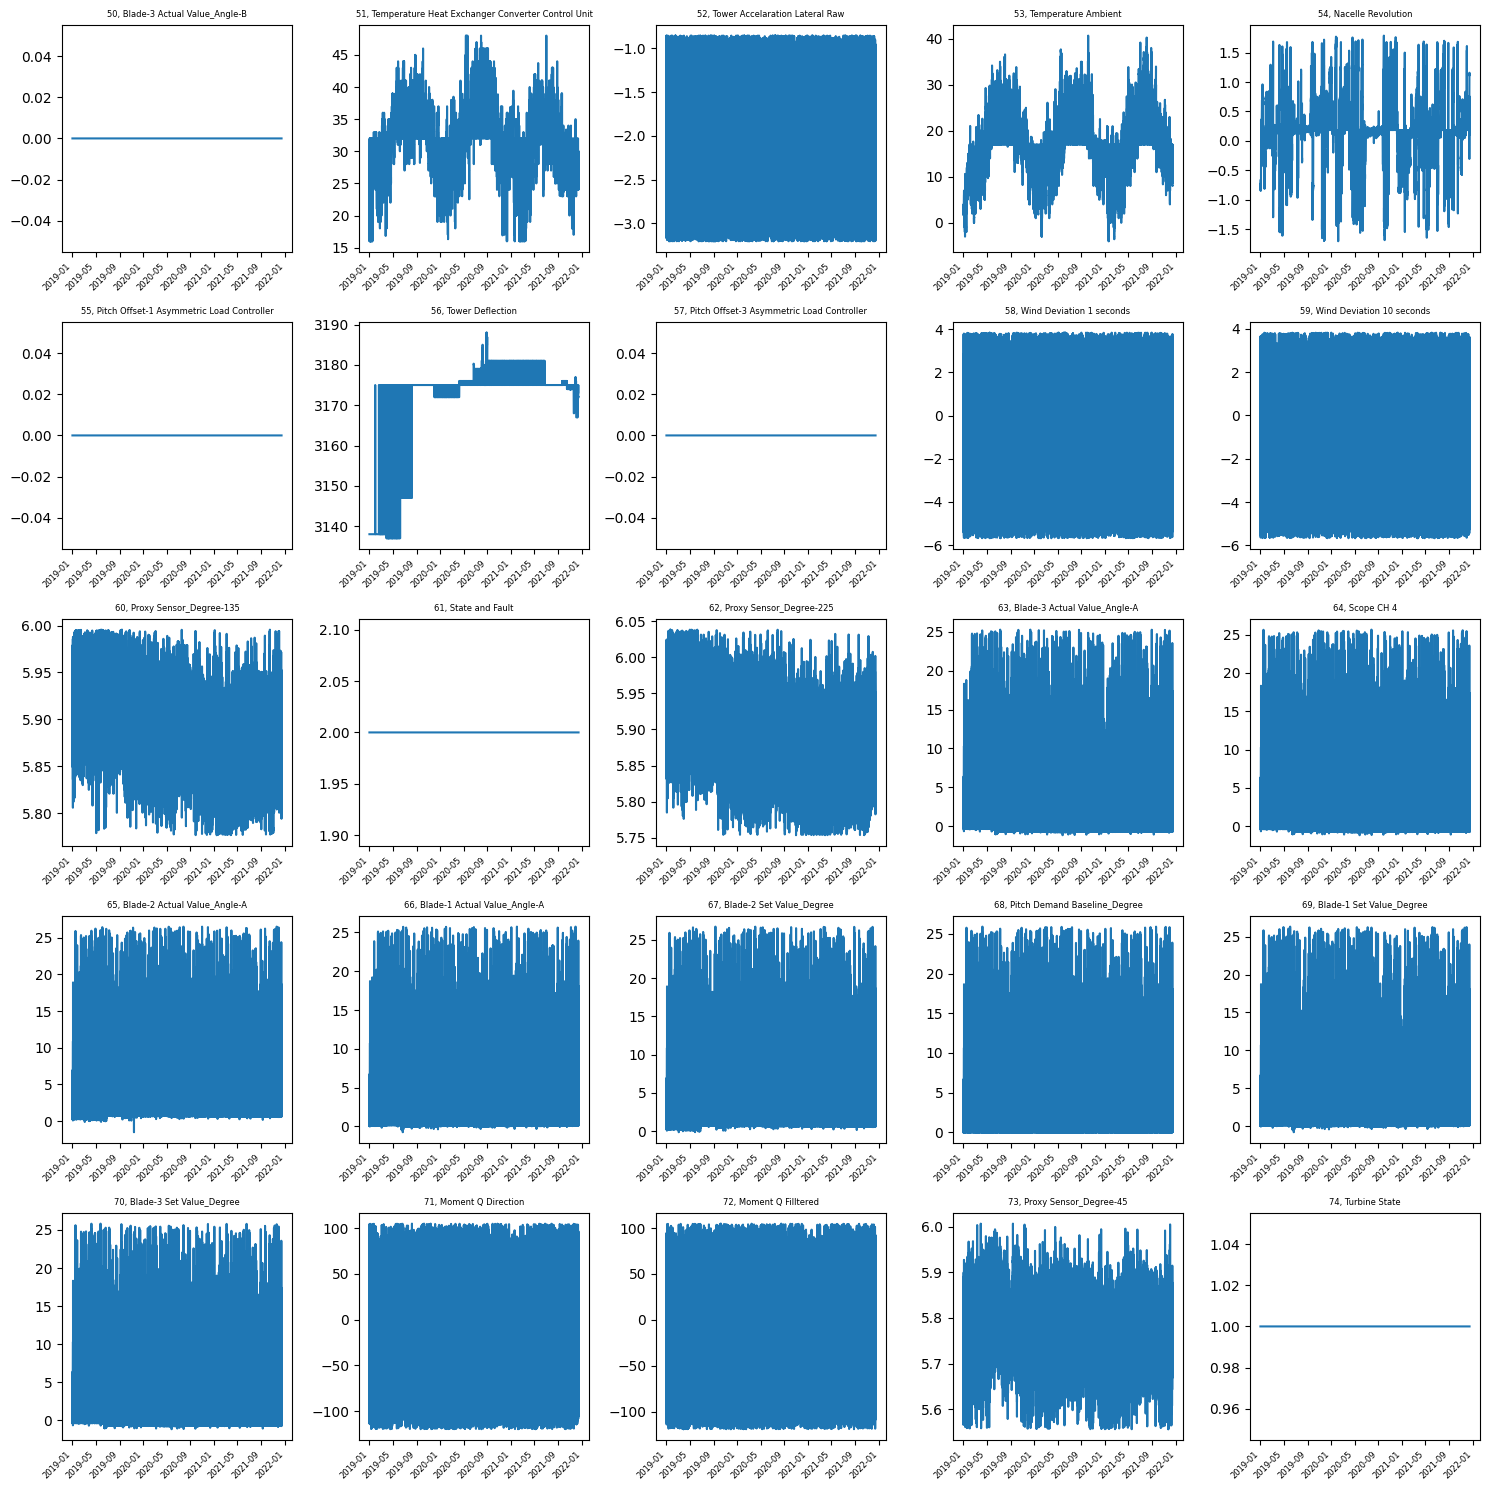

In [8]:

# time series for each feature
fig_fun(df_feature_clean,0,25)
plt.show()
fig_fun(df_feature_clean,25,50)
plt.show()
fig_fun(df_feature_clean,50,75)

## Droping columns <a class="anchor" id="drop_column"></a>
The following colums are dropped since time series plot doesnot show any varibailiy or `20,21,39,40,42,43,44,47,48,49,50,55,56,57,61,74`

In [9]:
columns_to_remove=[20,21,39,40,42,43,44,47,48,49,50,55,56,57,61,74]
df_feature_clean_= df_feature_clean.drop(df_feature_clean.columns[columns_to_remove],axis=1)
df_feature_clean_.head()

,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Temperature Axis Box-3,Voltage C-N,Temperature Axis Box-2,Temperature Axis Box-1,Voltage B-N,Nacelle Position_Degree,Converter Control Unit Voltage,Temperature Battery Box-3,Temperature Battery Box-2,Temperature Battery Box-1,Hydraulic Prepressure,Angle Rotor Position,Temperature Tower Base,Line Frequency,Tower Accelaration Normal Raw,Torque Offset Tower Feedback,Temperature Heat Exchanger Converter Control Unit,Tower Accelaration Lateral Raw,Temperature Ambient,Nacelle Revolution,Wind Deviation 1 seconds,Wind Deviation 10 seconds,Proxy Sensor_Degree-135,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Proxy Sensor_Degree-315
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,56.158333,55.000000,55.000000,35.873798,-205.350006,57.0,-212.126663,28.000000,52.618332,264.949768,265.629913,-0.953030,25.0,20.110001,395.029999,17.715000,392.086670,20.0,20.0,392.413330,10.773334,682.044983,11.0,12.0,11.0,72.210175,181.896973,15.140000,50.018833,2.025269,0.076724,24.0,-1.582408,3.976667,-0.761741,-2.923333,-3.011667,5.909392,5.957316,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,37.867054,39.281124,5.732657,5.779913
2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,57.000000,55.174999,55.174999,41.370548,-176.223328,57.0,-183.403336,28.000000,53.060001,3.340425,3.055089,-0.971856,25.0,20.424999,396.133331,17.459999,392.931671,20.0,20.0,393.040009,4.976666,683.515015,11.0,12.0,11.0,72.220482,178.224670,14.948334,50.006634,2.632190,0.323242,24.0,-2.231261,4.000000,-0.777843,-3.033333,-2.975000,5.892997,5.868237,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-90.169106,-89.018669,5.813177,5.796757
2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,57.775002,56.000000,56.000000,44.466202,-105.058334,57.0,-112.143333,28.763334,54.000000,75.649010,75.435135,-0.988937,25.0,21.000000,397.138336,18.000000,394.028320,20.0,20.0,393.941681,0.636667,685.244995,11.0,12.0,11.0,72.364883,184.183014,14.171667,49.989101,2.117626,-0.032209,24.0,-2.469615,4.000000,-0.789898,1.053333,1.028333,5.898009,5.874691,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-88.556343,-88.422020,5.786413,5.772958
2019-01-01 00:30:00,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,58.683334,56.738335,56.738335,48.259949,-150.923340,57.0,-157.783340,29.000000,54.820000,192.707932,192.865723,-0.985741,25.0,21.100000,397.071655,18.000000,393.806671,20.0,20.0,393.823334,3.976667,684.938354,11.0,12.0,11.0,72.458626,182.428268,14.310000,50.015400,3.060992,0.000000,24.0,-2.026011,3.985000,-0.780620,-1.373333,-1.346667,5.915995,5.873512,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-9.652824,-9.428586,5.758913,5.728393
2019-01-01 00:40:00,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,59.623333,57.615002

# Feature Engineering  <a class="anchor" id="feature_engineering"></a>

In [10]:
#combine the feature dataframe with traget dataframe
df_combined=pd.concat([df_feature_clean_.loc[df_feature_clean_.index<=df_power.index[-1]].copy(),df_power],axis=1)
# Calculate the correlation matrix
featr_corelation_matr=df_combined.corr()


<Axes: >

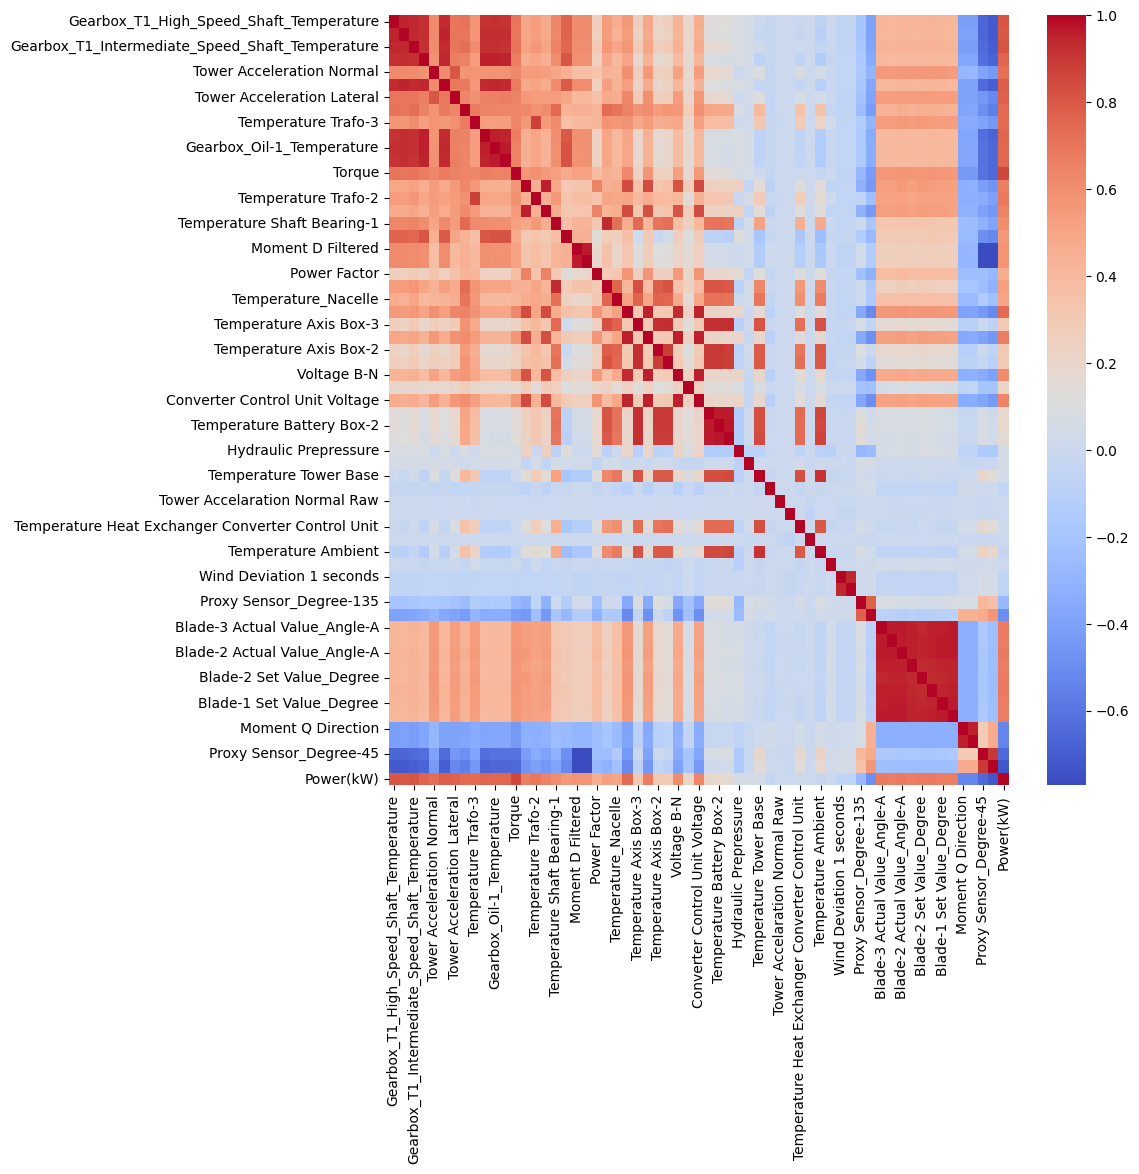

In [11]:

plt.figure(figsize=(10, 10))
sns.heatmap(featr_corelation_matr,cmap='coolwarm')


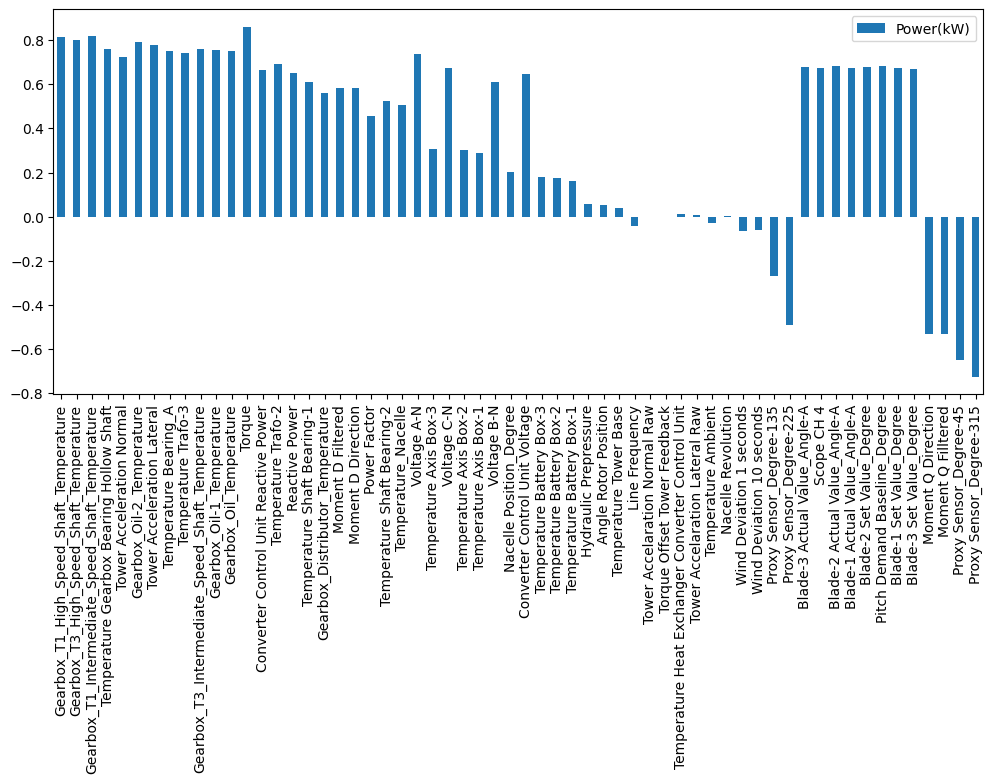

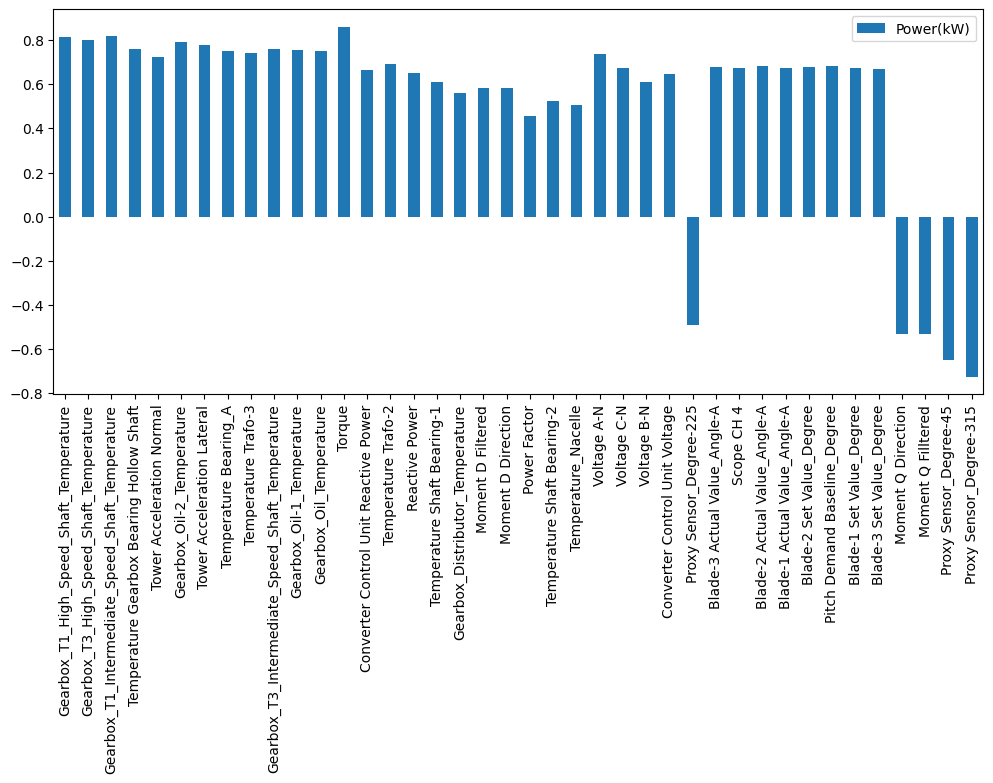

In [12]:

# Extract correlation of features with the target variable
correlation_with_target = featr_corelation_matr[['Power(kW)']][:-1]
correlation_with_target.plot(kind='bar',figsize=(12,5));
plt.xticks(rotation=90);


# asbsoulte correlation greater than .45 is considered here 

features_selectd=(correlation_with_target[abs(correlation_with_target)>.45]).dropna()
features_selectd.plot(kind='bar',figsize=(12,5));
plt.xticks(rotation=90);
df_selectd_features=df_combined[features_selectd.index]

# df_combined[list(features_selectd.index)+['Power(kW)']]

In [13]:
# select features from the data frame 

# df_combined_=df_combined[list(features_selectd.index)+['Power(kW)']]

df_selectd_features.shape

(136730, 40)

### Identifying features from the time series of Power data <a class="anchor" id="feature_time_series"></a>

In [14]:
def create_features(df):
    """
    Deriving time series features from the time series index(time stamp).
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
#     df['weekofyear'] = df.index.isocalendar().week
    return df


combined_features_target=pd.concat([create_features(df_selectd_features),df_power],axis=1)
combined_features_target.head()

,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Voltage C-N,Voltage B-N,Converter Control Unit Voltage,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Proxy Sensor_Degree-315,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,Power(kW)
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,57.000000,59.000000,52.000000,56.158333,47.053776,57.000000,18.890772,35.000000,48.576668,56.158333,55.000000,55.000000,35.873798,-205.350006,57.0,-212.126663,28.000000,52.618332,264.949768,265.629913,-0.953030,25.0,20.110001,395.029999,392.086670,392.413330,682.044983,5.957316,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,37.867054,39.281124,5.732657,5.779913,0,1,1,1,2019,1,1,705.876648
2019-01-01 00:10:00,57.693333,59.485001,52.450001,57.000000,64.969742,57.413334,28.560265,35.233334,48.000000,57.000000,55.174999,55.174999,41.370548,-176.223328,57.0,-183.403336,28.000000,53.060001,3.340425,3.055089,-0.971856,25.0,20.424999,396.133331,392.931671,393.040009,683.515015,5.868237,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-90.169106,-89.018669,5.813177,5.796757,0,1,1,1,2019,1,1,884.711670
2019-01-01 00:20:00,59.000000,60.756668,53.536667,57.775002,51.149670,58.728333,34.228813,36.000000,48.053333,57.775002,56.000000,56.000000,44.466202,-105.058334,57.0,-112.143333,28.763334,54.000000,75.649010,75.435135,-0.988937,25.0,21.000000,397.138336,394.028320,393.941681,685.244995,5.874691,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-88.556343,-88.422020,5.786413,5.772958,0,1,1,1,2019,1,1,982.875000
2019-01-01 00:30:00,59.881668,61.563332,54.413334,58.683334,58.740929,59.518333,35.593220,36.000000,48.788334,58.683334,56.738335,56.738335,48.259949,-150.923340,57.0,-157.783340,29.000000,54.820000,192.707932,192.865723,-0.985741,25.0,21.100000,397.071655,393.806671,393.823334,684.938354,5.873512,-0.318974,-0.318974,0.272715,0.055473,0.267122,0.0,0.058617,-0.325738,-9.652824,-9.428586,5.758913,5.728393,0,1,1,1,2019,1,1,1115.943359
2019-01-01 00:40:00,61.290001,62.586666,55.485001,59.623333,53.264774,60.665001,38.552731,36.000000,49.000000,59.623333,57.615002,57.615002,52.421284,-165.591660,57.0,-172.368332,29.000000,55.756668,312.397583,313.844055,-0.987186,25.0,21.370001,397.019989,393.663330,393.859985,684.853333,5.875549,-0.324344,-0.324344,0.273919,0.053982,0.267612,0.0,0.058703,-0.325443,-9.652824,-9.428586,5.724591,5.687730,0,1,1,1,2019,1,1,1263.841675


## Scaling the feature values

In [15]:


from sklearn.preprocessing import StandardScaler, OneHotEncoder
standard_scaler= StandardScaler()

all_features_scaled=pd.DataFrame(standard_scaler.fit_transform(combined_features_target.iloc[:,:-1]),columns=combined_features_target.columns[:-1]).set_index(combined_features_target.index)


# Combine the scaled features with the target
all_features_scaled_target = pd.concat([all_features_scaled, combined_features_target.iloc[:, [-1]]], axis=1)

all_features_scaled_target.head()


,Gearbox_T1_High_Speed_Shaft_Temperature,Gearbox_T3_High_Speed_Shaft_Temperature,Gearbox_T1_Intermediate_Speed_Shaft_Temperature,Temperature Gearbox Bearing Hollow Shaft,Tower Acceleration Normal,Gearbox_Oil-2_Temperature,Tower Acceleration Lateral,Temperature Bearing_A,Temperature Trafo-3,Gearbox_T3_Intermediate_Speed_Shaft_Temperature,Gearbox_Oil-1_Temperature,Gearbox_Oil_Temperature,Torque,Converter Control Unit Reactive Power,Temperature Trafo-2,Reactive Power,Temperature Shaft Bearing-1,Gearbox_Distributor_Temperature,Moment D Filtered,Moment D Direction,Power Factor,Temperature Shaft Bearing-2,Temperature_Nacelle,Voltage A-N,Voltage C-N,Voltage B-N,Converter Control Unit Voltage,Proxy Sensor_Degree-225,Blade-3 Actual Value_Angle-A,Scope CH 4,Blade-2 Actual Value_Angle-A,Blade-1 Actual Value_Angle-A,Blade-2 Set Value_Degree,Pitch Demand Baseline_Degree,Blade-1 Set Value_Degree,Blade-3 Set Value_Degree,Moment Q Direction,Moment Q Filltered,Proxy Sensor_Degree-45,Proxy Sensor_Degree-315,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,Power(kW)
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.336119,0.352903,0.262449,0.299203,-0.164024,0.332598,-0.687098,-0.364497,-0.924000,0.293972,0.366685,0.364830,-0.236624,-0.817437,-0.760277,-0.814120,-1.354029,0.634073,0.961785,0.968493,-1.392102,-1.181218,-1.349837,-1.123831,-1.174073,-1.184739,-1.212129,1.172899,-0.461922,-0.462102,-0.596615,-0.52285,-0.594672,-0.519416,-0.524067,-0.460748,1.170829,1.206095,-0.712411,-0.319883,-1.658398,-1.004559,-1.237668,-1.497472,-1.107128,-1.628174,-1.657399,705.876648
2019-01-01 00:10:00,0.396110,0.394308,0.308285,0.389606,0.282069,0.370730,-0.207342,-0.346858,-0.975583,0.384589,0.386224,0.384481,-0.105378,-0.711294,-0.760277,-0.706067,-1.354029,0.687813,-0.786796,-0.789562,-1.414622,-1.181218,-1.293122,-0.882387,-0.976688,-1.017274,-1.008195,-0.628048,-0.461922,-0.462102,-0.596615,-0.52285,-0.594672,-0.519416,-0.524067,-0.460748,-2.134432,-2.110030,0.441129,-0.107558,-1.658398,-1.004559,-1.237668,-1.497472,-1.107128,-1.628174,-1.657399,884.711670
2019-01-01 00:20:00,0.509171,0.502873,0.418971,0.472849,-0.062040,0.492044,0.073905,-0.288899,-0.970812,0.468028,0.478337,0.477122,-0.031463,-0.451955,-0.760277,-0.437997,-1.241628,0.802187,-0.303490,-0.304945,-1.435053,-1.181218,-1.189594,-0.662460,-0.720521,-0.776325,-0.768200,-0.497547,-0.461922,-0.462102,-0.596615,-0.52285,-0.594672,-0.519416,-0.524067,-0.460748,-2.092799,-2.094608,0.057706,-0.407556,-1.658398,-1.004559,-1.237668,-1.497472,-1.107128,-1.628174,-1.657399,982.875000
2019-01-01 00:30:00,0.585459,0.571740,0.508266,0.570413,0.126976,0.564924,0.141601,-0.288899,-0.905066,0.565822,0.560773,0.560032,0.059121,-0.619096,-0.760277,-0.609688,-1.206779,0.901960,0.478925,0.481304,-1.431231,-1.181218,-1.171589,-0.677052,-0.772296,-0.807950,-0.810739,-0.521397,-0.461922,-0.462102,-0.596615,-0.52285,-0.594672,-0.519416,-0.524067,-0.460748,-0.055900,-0.052890,-0.336270,-0.969323,-1.658398,-1.004559,-1.237668,-1.497472,-1.107128,-1.628174,-1.657399,1115.943359
2019-01-01 00:40:00,0.707316,0.659104,0.617424,0.671378,-0.009375,0.670709,0.288438,-0.288899,-0.886132,0.667026,0.658655,0.658475,0.158481,-0.672550,-0.760277,-0.664555,-1.206779,1.015929,1.278923,1.291308,-1.432960,-1.181218,-1.122976,-0.688358,-0.805779,-0.798156,-0.822534,-0.480203,-0.463136,-0.463313,-0.596344,-0.52319,-0.594561,-0.519416,-0.524047,-0.460681,-0.055900,-0.052890,-0.827968,-1.481897,-1.658398,-1.004559,-1.237668,-1.497472,-1.107128,-1.628174,-1.657399,1263.841675


# Split the data into train and test <a class="anchor" id="split_data"></a>

The data is divideed into trian and test 80 percent for train and 20% for test



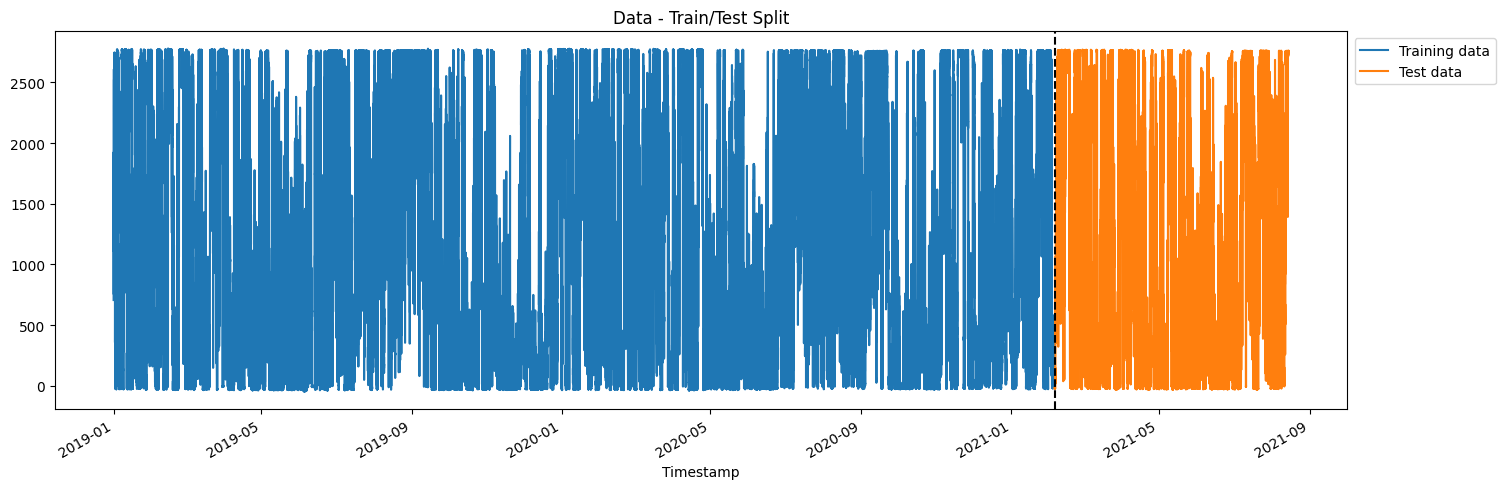

In [16]:
# training data 

# split the data 80-20%
time_stamp_80=int(combined_features_target.shape[0]*.8)
# Train_data=combined_features_target.iloc[:time_stamp_80,:]
Train_data=all_features_scaled_target.iloc[:time_stamp_80,:]

# test data 
# Test_data=combined_features_target.iloc[time_stamp_80:,:]
Test_data=all_features_scaled_target.iloc[time_stamp_80:,:]


TARGET='Power(kW)'

fig, ax = plt.subplots(figsize=(15, 5))
Train_data[TARGET].plot(ax=ax, label='Training data', title='Data - Train/Test Split')
Test_data[TARGET].plot(ax=ax, label='Test Set')
ax.axvline(combined_features_target.index[time_stamp_80], color='black', ls='--')
ax.legend(['Training data', 'Test data'],loc='upper right', bbox_to_anchor=(1.12, 1))
plt.tight_layout()




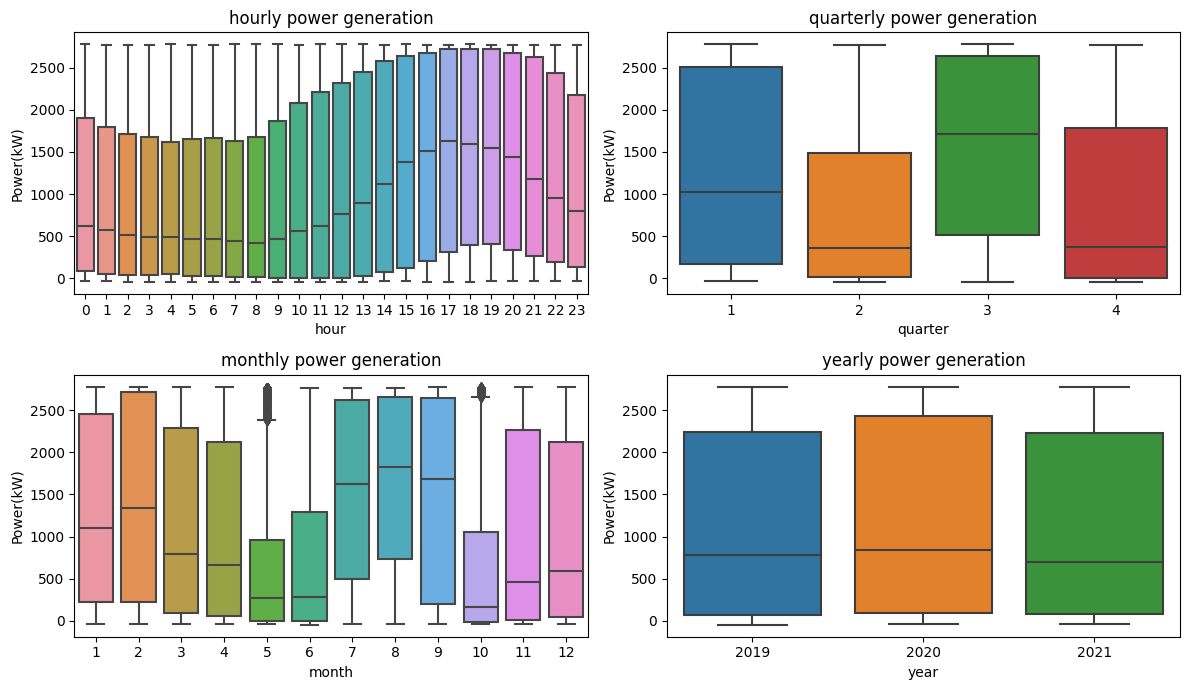

In [17]:
time_series_feature=all_features_scaled_target[all_features_scaled_target.columns[40:47]]

df_ = pd.concat([time_series_feature,df_power],axis=1)

fig,axs = plt.subplots(2,2,figsize=(12,7))
axs=axs.reshape(-1)
sns.boxplot(data = combined_features_target, x= 'hour', y= 'Power(kW)',ax=axs[0])
axs[0].set_title('hourly power generation')
sns.boxplot(data = combined_features_target, x='quarter', y='Power(kW)',ax=axs[1])
axs[1].set_title('quarterly power generation')
sns.boxplot(data=combined_features_target, x='month', y='Power(kW)',ax=axs[2])
axs[2].set_title('monthly power generation')
sns.boxplot(data=combined_features_target, x='year', y='Power(kW)',ax=axs[3])
axs[3].set_title('yearly power generation')
plt.tight_layout()

# Model creation <a class="anchor" id="model_creat"></a>

## Model 1
1. The first the model is trained without the time series features. 


In [18]:
FEATURES = list(all_features_scaled_target.columns[:-8])
TARGET='Power(kW)'
X_train = Train_data[FEATURES]
y_train = Train_data[TARGET]

X_test = Test_data[FEATURES]
y_test = Test_data[[TARGET]]

In [19]:
XGB_model_1 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
XGB_model_1.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[09:44:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1569.69987	validation_1-rmse:1481.80762
[100]	validation_0-rmse:595.91115	validation_1-rmse:562.29789
[200]	validation_0-rmse:245.40619	validation_1-rmse:231.22267
[300]	validation_0-rmse:126.74313	validation_1-rmse:119.48431
[400]	validation_0-rmse:92.92577	validation_1-rmse:87.95065
[500]	validation_0-rmse:83.05311	validation_1-rmse:80.84578
[600]	validation_0-rmse:78.12819	validation_1-rmse:77.34808
[700]	validation_0-rmse:74.40839	validation_1-rmse:74.43905
[800]	validation_0-rmse:71.56213	validation_1-rmse:71.94726
[900]	validation_0-rmse:69.26282	validation_1-rmse:69.78628
[999]	validation_0-rmse:67.71864	validation_1-rmse:68.56783


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

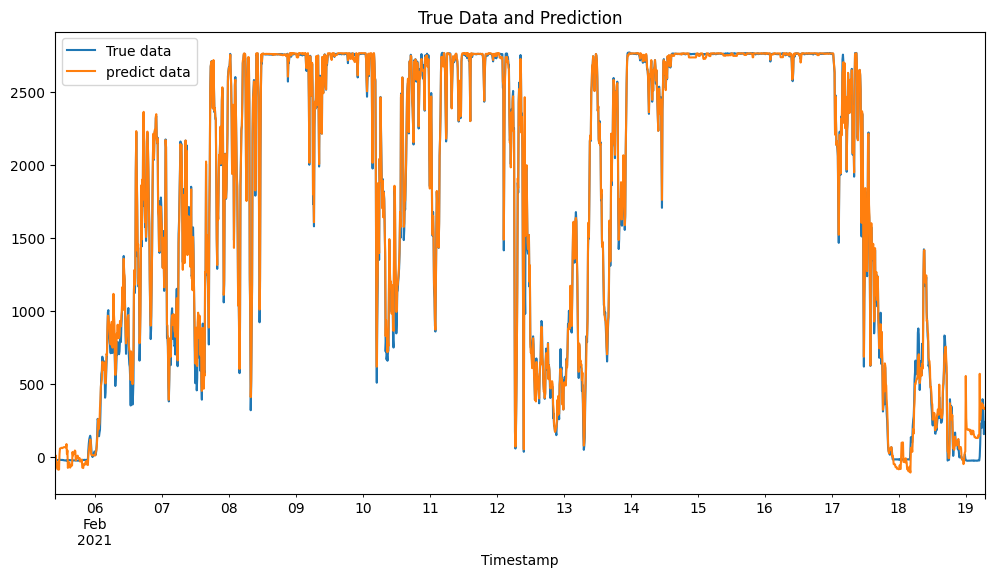

In [20]:
fig,ax=plt.subplots(figsize=(12,6))

y_test['predict']=XGB_model_1.predict(X_test)

y_test[TARGET].iloc[:2000].plot(ax=ax,label='True data')
y_test['predict'][:2000].plot(ax=ax,label='predict data')

plt.legend()
ax.set_title('True Data and Prediction')
plt.show()

# df_power['prediction'].plot(ax=ax, style='.')

<Axes: ylabel='Frequency'>

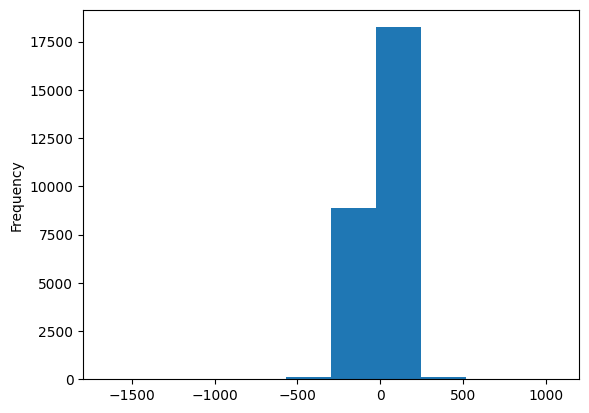

In [21]:
(y_test[TARGET]-y_test['predict']).plot(kind='hist',bins=10)

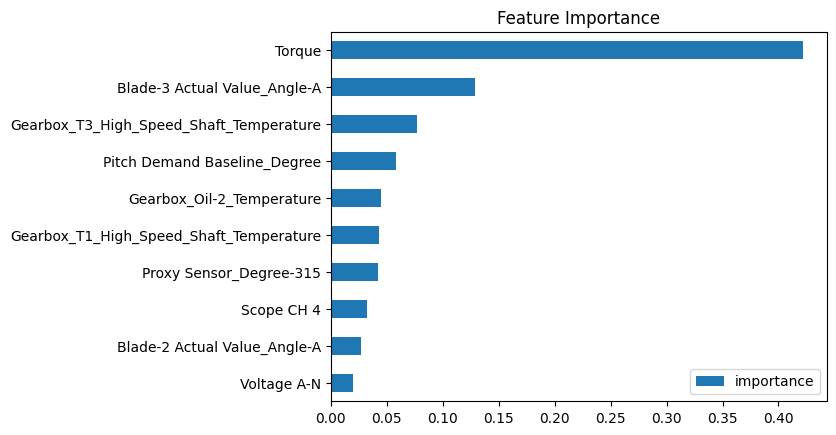

In [22]:
fi = pd.DataFrame(data=XGB_model_1.feature_importances_,
             index=XGB_model_1.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').iloc[-10:].plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(y_test[TARGET], y_test['predict']))
print(f'RMSE Score on Test set: {score:0.2f}')

print('GBRModel Train Score is : ' , XGB_model_1.score(X_train, y_train))
print('GBRModel Test Score is : ' , XGB_model_1.score(X_test, y_test.iloc[:,0]))

RMSE Score on Test set: 68.57
GBRModel Train Score is :  0.9960809069871195
GBRModel Test Score is :  0.9958239202658458


## Model 2
The second model is trained with the incorporation of time series features in addition to the features from the first model. 

It includes the following 
additional features:
`FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth'].`


In [24]:

FEATURES = list(all_features_scaled_target.columns[:-1])
TARGET='Power(kW)'
X_train = Train_data[FEATURES]
y_train = Train_data[TARGET]

X_test = Test_data[FEATURES]
y_test = Test_data[[TARGET]]

In [25]:
XGB_model_2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
XGB_model_2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[09:46:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1569.69987	validation_1-rmse:1481.80762
[100]	validation_0-rmse:595.91115	validation_1-rmse:562.29789
[200]	validation_0-rmse:245.40619	validation_1-rmse:231.22267
[300]	validation_0-rmse:126.74313	validation_1-rmse:119.48431
[400]	validation_0-rmse:92.92577	validation_1-rmse:87.95065
[500]	validation_0-rmse:82.97275	validation_1-rmse:80.68218
[600]	validation_0-rmse:78.22602	validation_1-rmse:77.44418
[700]	validation_0-rmse:75.15064	validation_1-rmse:74.65960
[800]	validation_0-rmse:72.67346	validation_1-rmse:72.01395
[900]	validation_0-rmse:69.98418	validation_1-rmse:69.23928
[999]	validation_0-rmse:67.81914	validation_1-rmse:67.27784


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

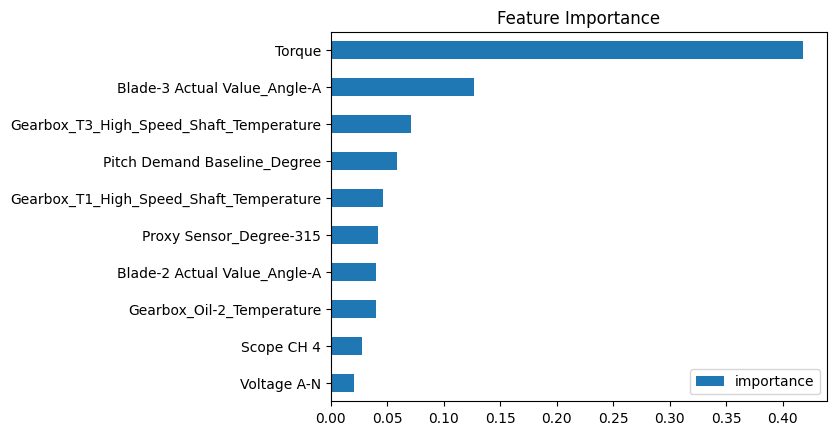

In [26]:
fi = pd.DataFrame(data=XGB_model_2.feature_importances_,
             index=XGB_model_2.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').iloc[-10:].plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

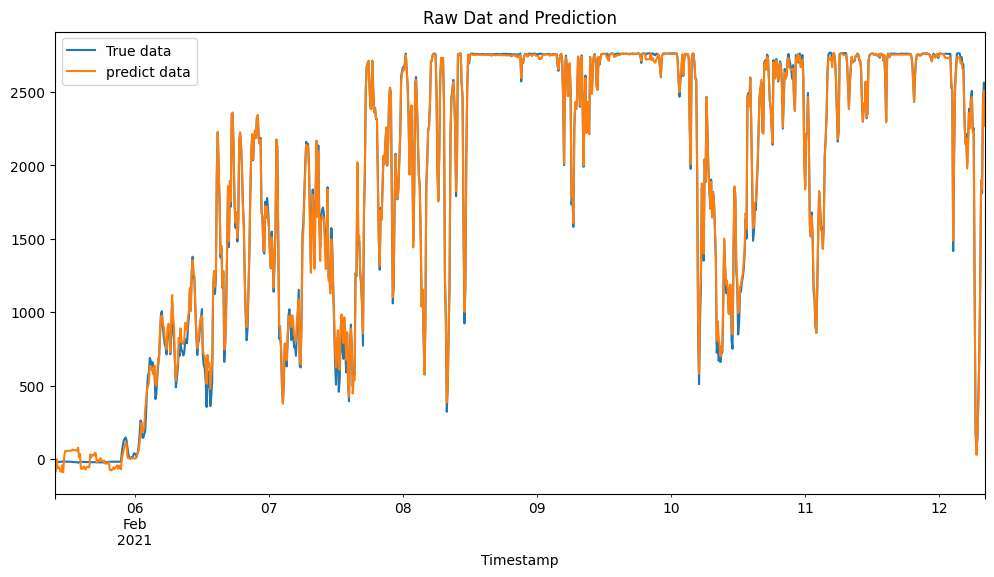

In [27]:

fig,ax=plt.subplots(figsize=(12,6))

y_test['predict']=XGB_model_2.predict(X_test)

y_test[TARGET].iloc[:1000].plot(ax=ax,label='True data')
y_test['predict'][:1000].plot(ax=ax,label='predict data')

plt.legend()
ax.set_title('Raw Dat and Prediction')
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(y_test[TARGET], y_test['predict']))
print(f'RMSE Score on Test set: {score:0.2f}')

print('GBRModel Train Score is : ' , XGB_model_2.score(X_train, y_train))
print('GBRModel Test Score is : ' , XGB_model_2.score(X_test, y_test.iloc[:,0]))

RMSE Score on Test set: 67.28
GBRModel Train Score is :  0.9960692653657769
GBRModel Test Score is :  0.9959795743635276


# Prediction

In [29]:
# # test data for submission
test_feature=df_feature.loc[df_feature.index>df_power.index[-1]]
test_feature=create_features(test_feature[df_selectd_features.columns])
X_test=standard_scaler.fit_transform(test_feature)

                                      
y_predict=XGB_model_2.predict(X_test)




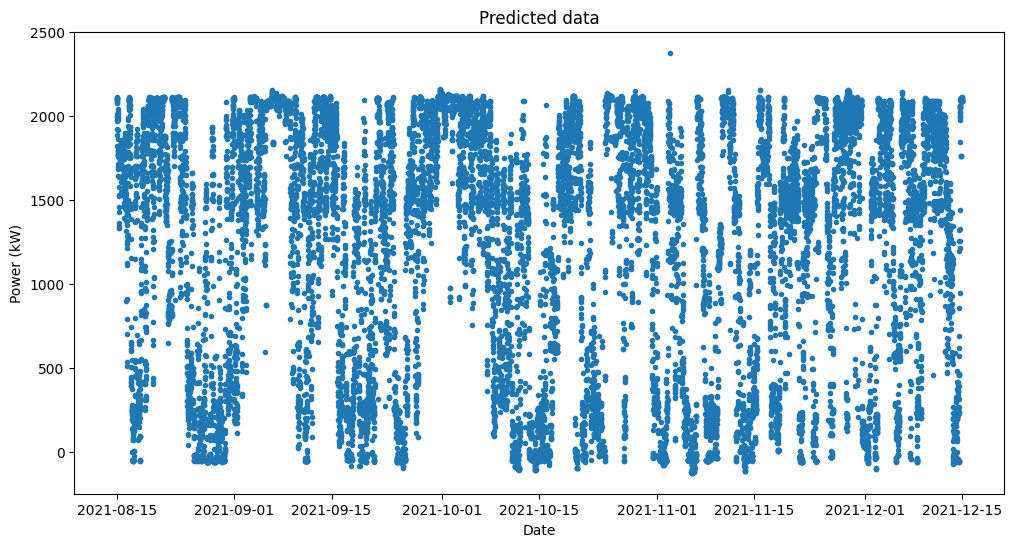

In [30]:
fig,ax=plt.subplots(figsize=(12,6))


ax.plot(test_feature.index,y_predict,'.')
ax.set_title('Predicted data')
ax.set_ylabel('Power (kW)')
ax.set_xlabel('Date')
plt.show()
